## optimizer几种优化方法  

一类:`SGD`及其改进(加`Momentum`)  
另一类:`Per-parameter adaptive learning rate methods`（逐参数适应学习率方法），包括`AdaGrad、RMSProp、Adam`等。  

### SGD  
当训练数据N很大时，计算总的`loss function`来求梯度代价很大，所以一个常用的方法是计算训练集中的小批量`（minibatches）`，这就是`SGD`。  
`minibatch`的大小是一个超参数，通常使用2的指数，是因为在实际中许多向量化操作实现的时候，如果输入数据量是2的倍数，那么运算更快。  

`SGD`的缺点：  
（1）`Very slow progress along shallow dimension, jitter along steep direction`  
（2）到`local minima` 或者 `saddle point`会导致`gradient`为0，无法移动。而事实上，`saddle point` 问题在高维问题中会更加常见  

    torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)  

- `weight_decay (float, optional)`：`weight decay (L2 penalty) (default: 0)`即`L2regularization`，选择一个合适的权重衰减系数`λ`非常重要，这个需要根据具体的情况去尝试，初步尝试可以使用 `1e-4 `或者 `1e-3`  
- `dampening (float, optional)：dampening for momentum (default: 0) - nesterov (bool, optional)：enables Nesterov momentum (default: False)`

In [1]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np

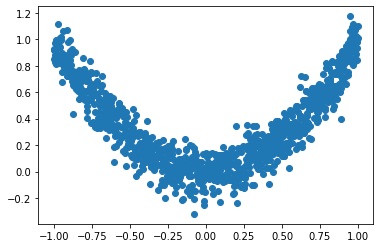

In [2]:
torch.manual_seed(1)

#hyper parameter 
Learning_rate = 0.01
Batch_size = 32
Epoch =16  

# fake dataset 
x = torch.unsqueeze(torch.linspace(-1,1,1000),dim=1)
y = x.pow(2)+0.1*torch.normal(torch.zeros(x.size()[0], 1), torch.ones(x.size()[0], 1))

# plot dataset
plt.scatter(x.numpy(),y.numpy())
plt.show()

In [3]:
# 加载数据
torch_dataset = Data.TensorDataset(x,y)
loader = Data.DataLoader(dataset=torch_dataset,batch_size=Batch_size,shuffle=True)
# 为每一种优化器创建一个神经网络 
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(1,20)
        self.predict = torch.nn.Linear(20,1)

    def forward(self,x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

net_SGD = Net()
net_Momentum = Net()
net_RMSprop = Net()
net_Adam = Net()
net_Adagrad = Net()

nets = [net_SGD,net_Momentum,net_RMSprop,net_Adam,net_Adagrad]
# 创建不同的优化器用来训练不同的网络
opt_SGD = torch.optim.SGD(net_SGD.parameters(),lr=Learning_rate)
opt_Momentum = torch.optim.SGD(net_Momentum.parameters(),lr=Learning_rate,momentum=0.8,nesterov=True)
opt_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(),lr=Learning_rate,alpha=0.9)
opt_Adam = torch.optim.Adam(net_Adam.parameters(),lr=Learning_rate,betas=(0.9,0.99))
opt_Adagrad = torch.optim.Adagrad(net_Adagrad.parameters(),lr=Learning_rate)

optimizers = [opt_SGD,opt_Momentum,opt_RMSprop,opt_Adam,opt_Adagrad]

criterion = torch.nn.MSELoss()
losses_his = [[],[],[],[],[]]  # 记录 training 时不同神经网络的 loss

epoch: 1/16,steps:32/1000


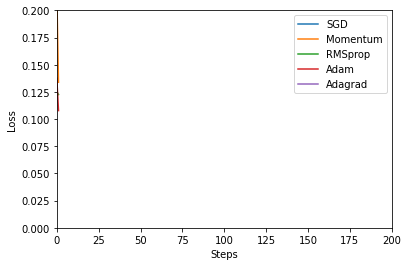

epoch: 1/16,steps:832/1000


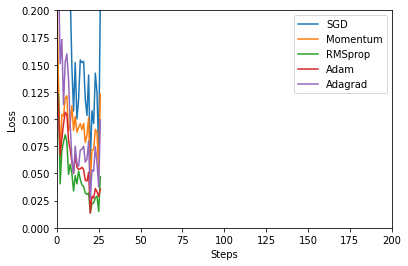

epoch: 8/16,steps:32/1000


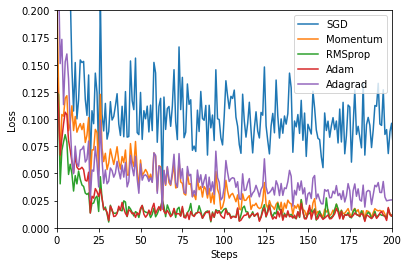

epoch: 8/16,steps:832/1000


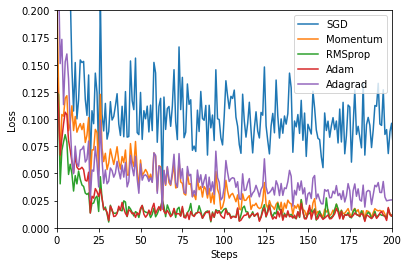

epoch: 15/16,steps:32/1000


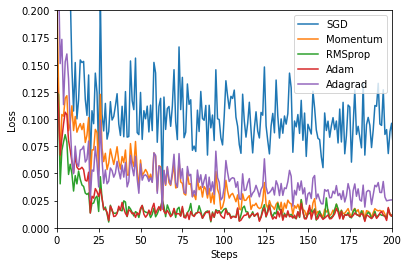

epoch: 15/16,steps:832/1000


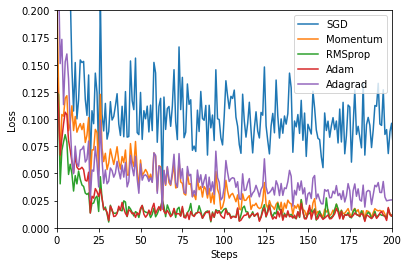

In [4]:
for epoch in range(Epoch):

    for step, (b_x, b_y) in enumerate(loader):
        for net,opt,l_his in zip(nets,optimizers,losses_his):
            output = net(b_x)
            loss=criterion(output,b_y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            l_his.append(loss.data.numpy())

        if step%25 == 1 and epoch%7==0:
            labels = ['SGD', 'Momentum', 'RMSprop', 'Adam','Adagrad']
            for i, l_his in enumerate(losses_his):
                plt.plot(l_his, label=labels[i])
            plt.legend(loc='best')
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.ylim((0, 0.2))
            plt.xlim((0, 200))
            print('epoch: {}/{},steps:{}/{}'.format(epoch+1,Epoch,step*Batch_size,len(loader.dataset)))
            plt.show()

### 学习率调整策略  

`torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1) `  
- `step_size(int)`- 学习率下降间隔数，若为 30，则会在 30、 60、 90…个 `step` 时，将学习率调整为 lr\*gamma。
- `gamma(float)`- 学习率调整倍数，默认为 0.1 倍，即下降 10 倍。
- `last_epoch(int)`- 上一个 `epoch` 数，这个变量用来指示学习率是否需要调整。当`last_epoch` 符合设定的间隔时，就会对学习率进行调整。当为-1 时，学习率设置为初始值。


`torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1)`  
适合后期调试使用  
- `milestones(list)`- 一个 `list`，每一个元素代表何时调整学习率， `list` 元素必须是递增的。如 `milestones=[30,80,120]`  
- `gamma(float)`- 学习率调整倍数，默认为 `0.1` 倍，即下降 `10` 倍。  


`torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)`   

$$ lr=lr*\gamma^{epoch} $$ 


`torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0, last_epoch=-1)`  
以余弦函数为周期，并在每个周期最大值时重新设置学习率。以初始学习率为最大学习率，以$2*T_{max}$为周期，在一个周期内先下降，后上升。 
$$\eta_t = \eta_{min} + \frac{1}{2}*(\eta_{max}-\eta_{min})*(1+cos(\frac{T_{cur}*\pi}{T_{max}}))$$  
$\eta_{max}$为初始学习率，$T_{cur}$为当前`epochs`, $\eta_{min}$常设为0.  
- `T_max(int)` - 一次学习率周期的迭代次数，即`T_max 个 epoch `之后重新设置学习率。  
- `eta_min(float)`- 最小学习率，即在一个周期中，学习率最小会下降到 `eta_min`，默认值为`0`。  



`torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10,    
verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)`  
- `mode(str)`- 模式选择，有 `min` 和 `max` 两种模式， `min` 表示当指标不再降低(如监测`loss`)， `max` 表示当指标不再升高(如监测 `accuracy`)。
- `factor(float)`- 学习率调整倍数(等同于其它方法的 `gamma`)，即学习率更新为 `lr = lr * factor`
- `patience(int)`- 忍受该指标多少个 `step` 不变化，当忍无可忍时，调整学习率。
- `verbose(bool)`- 是否打印学习率信息， `print(‘Epoch {:5d}: reducing learning rate of group {} to {:.4e}.’.format(epoch, i, new_lr))`  
- `threshold_mode(str)`- 选择判断指标是否达最优的模式，有两种模式， `rel` 和 `abs`  

当 `threshold_mode == rel，并且 mode == max 时， dynamic_threshold = best * ( 1 +threshold )；`  
当 `threshold_mode == rel，并且 mode == min 时， dynamic_threshold = best * ( 1 -threshold )；`  
当 `threshold_mode == abs，并且 mode== max 时， dynamic_threshold = best + threshold ；`  
当 `threshold_mode == rel，并且 mode == max 时， dynamic_threshold = best - threshold；`  

- `threshold(float)`- 配合 `threshold_mode` 使用。
- `cooldown(int)`- “冷却时间“，当调整学习率之后，让学习率调整策略冷静一下，让模型再训练一段时间，再重启监测模式。
- `min_lr(float or list)`- 学习率下限，可为 `float`，或者 `list`，当有多个参数组时，可用 `list` 进行设置。
- `eps(float)`- 学习率衰减的最小值，当学习率变化小于` eps` 时，则不调整学习率。


`torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1)`  

`lr=base_lr∗lmbda(self.last_epoch) lr = base_lr *lmbda(self.last_epoch)`  
`lr=base_lr∗lmbda(self.last_epoch)`  

### pytorch内部中optim和loss是如何交互的?

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [8]:
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)
x.shape

torch.Size([100, 1])

In [14]:
y = x.pow(2) + 0.2 * torch.rand(x.size())

In [10]:
y.shape

torch.Size([100, 1])

In [15]:
y.data

tensor([[1.0443],
        [1.1259],
        [1.0391],
        [0.9668],
        [1.0430],
        [0.9371],
        [0.8128],
        [0.7750],
        [0.7160],
        [0.8104],
        [0.6692],
        [0.6821],
        [0.7286],
        [0.6936],
        [0.6955],
        [0.4972],
        [0.6509],
        [0.5700],
        [0.5549],
        [0.5232],
        [0.5522],
        [0.5203],
        [0.4129],
        [0.3066],
        [0.4346],
        [0.2618],
        [0.3248],
        [0.3165],
        [0.2920],
        [0.2594],
        [0.1559],
        [0.2733],
        [0.2283],
        [0.1730],
        [0.2244],
        [0.1655],
        [0.1719],
        [0.2436],
        [0.1390],
        [0.1221],
        [0.2353],
        [0.1775],
        [0.1220],
        [0.0454],
        [0.0611],
        [0.0727],
        [0.0917],
        [0.0222],
        [0.1188],
        [0.1024],
        [0.1412],
        [0.0252],
        [0.0274],
        [0.0231],
        [0.0498],
        [0

In [11]:
x, y = torch.autograd.Variable(x), Variable(y)

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

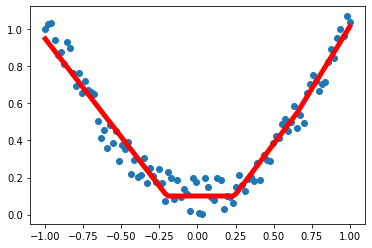

In [5]:
# 画图
# plt.scatter(x.data.numpy(), y.data.numpy())
# plt.show()

# 下面我们建立一个神经网络
# 以下两个函数必须必须
# torch的反向传播是由
class Net(nn.Module):
    def __init__(self, input_num, hidden_num, output_num):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(input_num, hidden_num)
        self.predict = torch.nn.Linear(hidden_num, output_num)

    def forward(self, x):
        x = self.hidden(x)
        x = func.relu(x)
        x = self.predict(x)
        return x

# 输入和输出没有悬念
# hidden层节点数打确立现在还没有头绪
net = Net(input_num=1,hidden_num=10,output_num=1)
print(net)
# 下面就是训练过程
# optimizer 是训练的工具
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)  # 传入 net 的所有参数, 学习率
# 预测值和真实值的误差计算公式 (均方差)
loss_func = torch.nn.MSELoss()

# time是训练次数
for time in range(100):
    prediction = net(x)
    loss = loss_func(prediction, y)

    # pytorch里面的数据是怎么交互打呢？
    # 清空上一步的残余更新参数值
    optimizer.zero_grad()

    # 误差反向传播, 计算参数更新值
    loss.backward()

    # 将参数更新值施加到 net 的 parameters 上
    optimizer.step()

prediction = net(x)
plt.cla()
plt.scatter(x.data.numpy(), y.data.numpy())
plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
plt.text(0.5, 0, 'Loss=%.4f' % loss.data[0], fontdict={'size': 20, 'color':  'red'})
plt.show()